In [1]:
%load_ext autoreload  
%autoreload 2

In [2]:
import pandas as pd
import geopandas as gpd
import swifter

pd.set_option("display.max_columns", None)
import numpy as np
import matplotlib.pyplot as plt
import stc_unicef_cpi.data.process_geotiff as pg
import h3.api.numpy_int as h3

from pathlib import Path


In [84]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
tiff_dir = base_dir / "500m_res"
econ_dir = base_dir / "econ"
clean_base = base_dir / "nga_clean_v2.csv"
rwi_path = base_dir / "NGA_relative_wealth_index.csv"
comm_zns = base_dir / "commuting-zones-bdrys.csv"
connectivity_dir = base_dir / "connectivity"
fb_conn = connectivity_dir / "fb_nigeria.csv"

int_dir = Path("../data/interim/")



# Gen rows for model training params

In [ ]:
c1 = np.array(["all", "nigeria", "senegal"])
c2 = np.array(["normal", "stratified", "spatial"])
c3 = np.array(["all", "health", "nutrition","av-3-prevalence",
            "av-4-prevalence",])
c4 = np.array(["none", "mean", "median", "knn", "linear", "rf"])
c5 = np.array(["none", "standard", "minmax", "robust"])
c6 = np.array(["none", "log", "power"])
c7 = np.array(["normal", "stratified", "spatial"])
c8 = np.array(["true", "false"])
c9 = np.array(["true", "false"])
c10 = np.array(["true", "false"])

params = np.array(np.meshgrid(c1, c2, c3, c4, c5, c6, c7, c8, c9, c10)).T.reshape(-1, 10)
np.savetxt('../src/stc_unicef_cpi/models/clean_params.txt',params,delimiter=' ',fmt='%s')

# Spatial CV tests

In [ ]:
from stc_unicef_cpi.data.cv_loaders import cv_split  

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga = world[world.name == "Nigeria"].geometry.__geo_interface__['features'][0]['geometry']
nga_hex = h3.polyfill(nga,res=7)

In [ ]:
base_dir = Path("/Users/johnf/Downloads/higher_res_dssg/")
all_data = base_dir / "clean_nga_w_autov1.csv"
thr_data = base_dir / "nga_clean_v2_thr30.csv"
all_df = pd.read_csv(all_data)
all_df["name_commuting_zone"] = all_df["name_commuting_zone"].astype("category")
thr_df = pd.read_csv(thr_data)
thr_all = all_df.set_index("hex_code").loc[thr_df.hex_code].reset_index()


In [ ]:
import seaborn as sns

k = 10
N = 1000
samp_hex = np.random.choice(thr_all["hex_code"], size=N, replace=False)
labels = np.random.rand(N)
folds = cv_split(samp_hex, labels=labels, k=k, mode="spatial")
# sns.distplot(folds,kde=False, bins=k)
fig, ax = plt.subplots(dpi=150)
latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex])
for _, test_idxs in folds:
    ax.scatter(latlongs[test_idxs, 1], latlongs[test_idxs, 0])
plt.show()


In [ ]:
from stc_unicef_cpi.data.cv_loaders import HexSpatialKFold

latlongs = np.array([h3.h3_to_geo(hex) for hex in samp_hex])
for train_idx, test_idx in HexSpatialKFold().split(samp_hex, labels):
    fig, ax = plt.subplots(dpi=150)
    ax.scatter(latlongs[train_idx, 1], latlongs[train_idx, 0], c="g")
    ax.scatter(latlongs[test_idx, 1], latlongs[test_idx, 0], c="r")
    plt.show()


# Connectivity data

In [ ]:
# import dask.dataframe as dd
# from dask.delayed import delayed
# parts = delayed(pd.read_excel)(connectivity_dir / 'cell_tower_nga.xlsx',
#                                     sheet_name=0)
# df = dd.from_delayed(parts)
nga_cell_df = pd.read_excel(connectivity_dir / "cell_tower_nga.xlsx", sheet_name=0)


In [ ]:
nga_cell_df.head()
# will just want radio (generation category - want counts / cell if possible)
# and possibly avg_signal, though generally 0
# Most likely just overall count will be most useful


In [ ]:
nga_cell_df["hex_code"] = nga_cell_df[["lat", "long"]].swifter.apply(
    lambda x: h3.geo_to_h3(x[0], x[1], resolution=7), axis=1
)


In [ ]:
nga_cell_df = nga_cell_df[["hex_code", "radio", "avg_signal"]]


In [ ]:
nga_cell_df.groupby(["hex_code", "radio"]).size().unstack(level=1).fillna(0).join(
    nga_cell_df.groupby("hex_code").avg_signal.mean()
).to_csv(connectivity_dir / "nga_cell_clean.csv")


In [ ]:
import shapely.wkt

# speed_df = dd.read_csv(connectivity_dir/"speedtest_world.csv",blocksize=25e6).set_index("Unnamed: 0")  # 25MB chunks
speed_df = pd.read_csv(Path('../data/external/connectivity') / "2021-10-01_performance_mobile_tiles.csv")
# speed_df["geometry"] = speed_df.geometry.swifter.apply(shapely.wkt.loads)
ctry = "Nigeria" 
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
ctry = world[world.name == ctry]

In [ ]:
speed_df.geometry.head()

In [ ]:
# alt version
bd_series = speed_df.geometry.str.replace("POLYGON\s\(+|\)","").str.split(r"\s|,\s")
speed_df['min_x'] = bd_series.str[1].astype('float')
speed_df['max_y'] = bd_series.str[-1].astype('float')
minx, miny, maxx, maxy = ctry.bounds.values.T.squeeze()
res_df = speed_df[speed_df.min_x.between(minx-1e-2,maxx+1e-2)&speed_df.max_y.between(miny-1e-2,maxy+1e-2)].copy()
res_df['geometry'] = res_df.geometry.swifter.apply(shapely.wkt.loads)
res_df = gpd.GeoDataFrame(res_df, crs="epsg:4326")

nga_speed_df = gpd.sjoin(
    res_df, ctry, how="inner", op="intersects"
)


In [ ]:
# original version 
speed_df["geometry"] = speed_df.geometry.swifter.apply(shapely.wkt.loads)
speed_df = gpd.GeoDataFrame(speed_df, crs="epsg:4326")
nga_speed_df = gpd.sjoin(
    speed_df, ctry, how="inner", op="intersects"
)


In [ ]:
# def centroid_lat_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[1]
#     except:
#         # assume wkt reading error
#         return np.nan
# def centroid_long_from_shply(wkt_str):
#     try:
#         return shapely.wkt.loads(wkt_str).centroid.coords.xy[0]
#     except:
#         # assume wkt reading error
#         return np.nan

# def centroid_latlong_from_shply(wkt_str):
#     try:
#         return np.array(shapely.wkt.loads(wkt_str).centroid.coords.xy).flatten()
#     except:
#         # assume wkt reading error
#         return np.array([np.nan,np.nan])

# # speed_df['lat'] = speed_df.geometry.apply(centroid_lat_from_shply, meta=('geometry', float))
# # speed_df['long'] = speed_df.geometry.apply(centroid_long_from_shply, meta=('geometry', float))
# # speed_df[['lat','long']] = speed_df.geometry.swifter.apply(centroid_latlong_from_shply)
# speed_df['lat'] = speed_df.geometry.swifter.apply(centroid_lat_from_shply)


In [ ]:
tmp = nga_speed_df.geometry.swifter.apply(
    lambda x: pd.Series(np.array(x.centroid.coords.xy).flatten())
)


In [ ]:
nga_speed_df[["long", "lat"]] = tmp


In [ ]:
nga_speed_df["hex_code"] = nga_speed_df[["lat", "long"]].swifter.apply(
    lambda row: h3.geo_to_h3(row[0], row[1], 7), axis=1
)


In [ ]:
nga_speed_df.to_csv(connectivity_dir / "speedtest_nga.csv", index=False)


# Main data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_cell_df = pd.read_csv(connectivity_dir / "nga_cell_clean.csv")
nga_speed_df = pd.read_csv(connectivity_dir / "speedtest_nga.csv")


In [ ]:
nga_speed_df.head()


In [ ]:
plt.scatter(nga_speed_df.long, nga_speed_df.lat)
plt.show()


In [ ]:
nga_speed_df = (
    nga_speed_df[
        ["hex_code", "avg_d_kbps", "avg_u_kbps", "avg_lat_ms", "tests", "devices"]
    ]
    .groupby("hex_code")
    .agg(
        {
            "avg_d_kbps": "mean",
            "avg_u_kbps": "mean",
            "avg_lat_ms": "mean",
            "tests": "sum",
            "devices": "sum",
        }
    )
)


In [ ]:
new_nga_df = nga_df.join(
    nga_cell_df.set_index("hex_code"), on=["hex_code"], how="left"
).join(nga_speed_df, on="hex_code", how="left")
# new_nga_df.iloc[:, 92:].fillna(0, inplace=True)


In [ ]:
new_nga_df.n_conflicts.fillna(0, inplace=True)


In [ ]:
new_nga_df.head()


# Reproject CISI data and add in again 

In [ ]:
from stc_unicef_cpi.data import process_geotiff as pg

cisi_dir = Path("/Users/johnf/Downloads/higher_res_dssg/CISI/010_degree")
pg.clip_tif_to_ctry(
    "/Users/johnf/Downloads/higher_res_dssg/CISI/010_degree/global.tif",
    ctry_name="Senegal",
    save_dir=None,
)


In [ ]:
pg.rxr_reproject_tiff_to_target(
    base_dir / "Nigeria_africa_cisi.tif",
    tiff_dir / "cpiPopData_500.tif",
    dest_path=base_dir / "nga_cisi.tif",
    verbose=True,
)


In [ ]:
alt_nga_df = pg.agg_tif_to_df(
    new_nga_df, base_dir / "nga_cisi.tif", rm_prefix="nga_", verbose=True
)


In [ ]:
alt_nga_df.drop(columns=["cii"], inplace=True)


In [ ]:
zero_fill_cols = [
    "n_conflicts",
    "GSM",
    "LTE",
    "NR",
    "UMTS",
    "tests",
    "devices",
]
alt_nga_df.fillna(value={col: 0 for col in zero_fill_cols}, inplace=True)
alt_nga_df.head()


In [ ]:
alt_nga_df = pg.agg_tif_to_df(
    alt_nga_df, tiff_dir / "cpiHealthAccData_500.tif", verbose=True
)


In [ ]:
autoh7 = pd.read_csv(base_dir / "autoencoder_highres7.csv", index_col=0)
autol7 = pd.read_csv(base_dir / "autoencoder_lowres7.csv", index_col=0)
autoh7.columns = [f"auto_h{i}" for i in range(len(autoh7.columns))]
autol7.columns = [f"auto_l{i}" for i in range(len(autol7.columns))]


In [ ]:
alt_nga_df = alt_nga_df.join(autoh7, on="hex_code", how="left").join(
    autol7, on="hex_code", how="left"
)


In [ ]:
alt_nga_df.head()


In [ ]:
commute_df = pd.read_csv(base_dir / "nga_clean_justnewcomm_zns.csv")[
    [
        "hex_code",
        "name_commuting_zone",
        "population_commuting",
        "road_len_commuting",
        "area_commuting",
    ]
]
if commute_df.columns[1] in alt_nga_df:
    alt_nga_df.drop(columns=commute_df.columns.tolist()[1:], inplace=True)
alt_nga_df = alt_nga_df.join(
    commute_df.set_index("hex_code"), on="hex_code", how="left"
)


In [ ]:
alt_nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv", index=False)


# Try mapping data to neighbours

In [ ]:
full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)
# Create variables for two or more deprivations
for k in range(2, 5):
    full_nga_data[f"dep_{k}_or_more_sev"] = full_nga_data["sumpoor_sev"] >= k


In [ ]:
plt.scatter(nga_df.LONGNUM, nga_df.LATNUM, c=nga_df.location)
plt.colorbar()
plt.show()


In [ ]:
full_nga_data.location.astype("category").describe()
# 1 is urban, 2 is rural


In [ ]:
full_nga_data["hex_incl_nbrs"] = full_nga_data[["location", "hex_code"]].apply(
    lambda row: h3.k_ring(row["hex_code"], 1)
    if row["location"] == 1
    else h3.k_ring(row["hex_code"], 2),
    axis=1,
)  # h3.hex_ring for hollow


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "_sev" in col]


In [ ]:
other_cols = [
    col
    for col in full_nga_data.columns
    if (
        "int" in str(full_nga_data[col].dtype)
        or "float" in str(full_nga_data[col].dtype)
    )
]
agg_dict = {col: "mean" for col in other_cols}
agg_dict.update({idx: ["mean", "count"] for idx in sev_cols})
# agg_dict.update({"hhid": "count"})
new_df = (
    full_nga_data.explode("hex_incl_nbrs").groupby(by=["hex_incl_nbrs"]).agg(agg_dict)
)
new_df.columns = ["_".join(col) for col in new_df.columns.values]


In [ ]:
new_df.rename(
    columns={
        f"{sev}_mean": f"{sev.replace('dep_','').replace('_sev','')}_prev"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)
new_df.rename(
    columns={
        f"{sev}_count": f"{sev.replace('dep_','').replace('_sev','')}_count"
        for sev in sev_cols
        if sev != "deprived_sev"
    },
    inplace=True,
)


In [ ]:
new_df = new_df[new_df.sumpoor_count >= 30].reset_index()

In [ ]:
new_df.drop(columns=['hex_code_mean'],inplace=True) 
new_df.rename(columns={'hex_incl_nbrs':'hex_code'},inplace=True)

In [ ]:
new_df.head()

In [ ]:
new_df.to_csv('../data/processed/expanded_nigeria_res7_thres30.csv')

In [ ]:
new_df.head()

In [ ]:
new_df.to_csv(base_dir / "nga_clean_expanded.csv")


In [ ]:
new_df = pd.read_csv(base_dir / "nga_clean_expanded.csv")
new_df[new_df["nutrition_count"] >= 10]


In [ ]:
sev_cols = [col for col in full_nga_data.columns if "sev" in col]


In [ ]:
full_nga_data["ndeps_missing"] = full_nga_data[sev_cols].isna().sum(axis=1)


In [ ]:
((6 - full_nga_data["ndeps_missing"] - full_nga_data["sumpoor_sev"]) < 0).sum()


In [ ]:
full_nga_data.ndeps_missing.describe()


In [ ]:
full_nga_data[sev_cols].info()


In [ ]:
full_nga_data.age.describe()


In [ ]:
# one vs all training


In [ ]:
import h3.api.numpy_int as h3


In [ ]:
res_level = 3
for col in sev_cols:
    full_nga_data[f"hex_code{res_level}"] = full_nga_data[["LATNUM", "LONGNUM"]].apply(
        lambda row: h3.geo_to_h3(*row.values, res_level), axis=1
    )
    count_df = full_nga_data.groupby(f"hex_code{res_level}")[col].count()
    _, bins = pd.qcut(count_df, [0, 0.05, 1.0], retbins=True)
    # print(f"5% cutoff for {col} is at {bins[1]}")
    if bins[1] < 30:
        quants = pd.cut(count_df, [0, 30, np.inf])
        cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
        print(f"Warning: cutoff at 30 for {col} removes {cut_prop*100:.2f}% of data")
        print(f"5% cutoff is at {bins[1]}")
        for thresh in [5, 10, 15, 20]:
            quants = pd.cut(count_df, [0, thresh, np.inf])
            cut_prop = quants.value_counts().sort_index().values[0] / len(count_df)
            print(f"Cutoff at {thresh} for {col} removes {cut_prop*100:.2f}% of data")
# count_df.hist(bins=100)
# plt.show()


In [ ]:
thr_df = nga_df.loc[count_df.values >= 30].copy()


In [ ]:
thr_df.to_csv(clean_base.parent / "nga_clean_v2_thr30.csv", index=False)


# First add higher res TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    tiff_dir,
    rm_prefix="cpi",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
merge_cols = [col for col in nga_df.columns if "Data_500" in col]
old_cols = [col for col in merge_cols if col.rstrip("Data_500") in nga_df.columns]
nga_df.drop(columns=old_cols, inplace=True)
nga_df.rename(columns={col: col.rstrip("Data_500") for col in merge_cols}, inplace=True)


In [ ]:
nga_df.to_csv(clean_base, index=False)


In [ ]:
pd.set_option("display.max_columns", None)
nga_df.head()


# Now add econ TIFF data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import glob

econ_tiffs = glob.glob(str(econ_dir / "*.tif"))


In [ ]:
econ_tiffs


In [ ]:
import rioxarray as rxr

# Convert econ tiffs to right resolution + CRS, rewrite to high_res dir
for i, econ_tiff in enumerate(econ_tiffs):
    with rxr.open_rasterio(econ_tiff) as data:
        name = Path(econ_tiff).name
        if "GDP_PPP" in name:
            data.attrs["long_name"] = ["GDP_PPP_1990", "GDP_PPP_2000", "GDP_PPP_2015"]
        elif "2019GDP" in name:
            data.attrs["long_name"] = ["GDP_2019"]
        elif "EC" in name:
            data.attrs["long_name"] = ["EC_2019"]
        data.rio.to_raster(econ_tiff)
    pg.rxr_reproject_tiff_to_target(
        econ_tiff,
        glob.glob(str(tiff_dir / "*.tif"))[0],
        tiff_dir / Path(econ_tiff).name,
        verbose=True,
    )


In [ ]:
high_res_econ_tifs = [
    name
    for name in glob.glob(str(tiff_dir / "*.tif"))
    if "GDP" in Path(name).name or "EC" in Path(name).name
]


In [ ]:
high_res_econ_tifs


In [ ]:
nga_df = pg.agg_tif_to_df(
    nga_df,
    high_res_econ_tifs,
    rm_prefix="Nigeria_",
    agg_fn=np.mean,
    max_records=int(1e5),
    replace_old=True,
    verbose=False,
)


In [ ]:
nga_df.head()


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add commuter zone data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
import geopandas as gpd

commzns_df = pd.read_csv(comm_zns)


In [ ]:
from shapely import wkt

commzns_df["geometry"] = commzns_df["geometry"].apply(wkt.loads)


In [ ]:
commzns_df = gpd.GeoDataFrame(commzns_df, crs="epsg:4326")


In [ ]:
commzns_df[commzns_df["country"] == "Nigeria"].head(2)


In [ ]:
# TODO: decide if will add


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Now add FB connectivity data

In [ ]:
nga_df = pd.read_csv(base_dir / "clean_nga_w_autov1.csv")


In [ ]:
nga_df.head()

In [ ]:
conn_df = pd.read_csv(fb_conn)
conn_gdf = gpd.GeoDataFrame(
    conn_df, geometry=gpd.points_from_xy(conn_df.long, conn_df.lat)
)


In [ ]:
conn_df["hex_code"] = conn_df[["lat", "long"]].swifter.apply(
    lambda row: h3.geo_to_h3(row[0], row[1], resolution=7), axis=1
)


In [ ]:
nga_df = nga_df.join(conn_df.set_index("hex_code")["estimate_dau"], on="hex_code")


In [ ]:
nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv", index=False)


In [ ]:
print(
    *sorted(
        [
            (name, val)
            for name, val in zip(
                nga_df.isna().sum(axis=0).index, nga_df.isna().sum(axis=0).values
            )
        ],
        key=lambda x: x[1],
    ),
    sep="\n"
)


In [ ]:
# only for inside train set - worth including or not extensible?
conn_gdf.plot()


# Finally add RWI data

In [ ]:
nga_df = pd.read_csv(clean_base)


In [ ]:
from pyquadkey2 import quadkey as qk
from shapely.geometry import Polygon

# qk.QuadKey()
top_left = qk.TileAnchor.ANCHOR_NW
top_right = qk.TileAnchor.ANCHOR_NE
bottom_right = qk.TileAnchor.ANCHOR_SE
bottom_left = qk.TileAnchor.ANCHOR_SW
getattr(qk.TileAnchor, bottom_right)


In [ ]:
test_idx = "010302121"
square = [
    qk.from_str(test_idx).to_geo(anchor=point)
    for point in [top_left, top_right, bottom_right, bottom_left]
]
square = Polygon(square)


In [ ]:
import h3.api.numpy_int as h3

ex_idx = h3.geo_to_h3(*square.boundary.coords[0], resolution=6)
hex = Polygon(h3.h3_to_geo_boundary(ex_idx))


In [ ]:
# create intersection and calculate percentage intersection based on areas
intersection = hex.intersection(square)
percent_area = intersection.area / square.area * 100


In [ ]:
percent_area


In [ ]:
nga_df.to_csv(clean_base, index=False)


# Add new target columns of proportion w > k deps

In [ ]:
nga_df = pd.read_csv(base_dir / "clean_nga_w_autov1.csv")

full_nga_data = pd.read_csv(
    "/Users/johnf/Downloads/raw_low_res_dssg/dhs/clean_nga_dhs.csv"
)


In [ ]:
for k in range(2,5): 
    full_nga_data[f"dep_{k}_or_more_sev"] = full_nga_data['sumpoor_sev'] >= k 

In [ ]:
k_or_more_df = full_nga_data.groupby(by=["hex_code"]).agg({col:np.mean for col in full_nga_data.columns if 'or_more' in col})

In [ ]:
k_or_more_df.melt()

In [ ]:
import seaborn as sns 

for k in range(2,5): 
    fig,ax = plt.subplots(dpi=200)
    # sns.histplot(data=k_or_more_df.melt(),x="value",hue="variable",element="step", fill=False, kde=True)
    sns.histplot(data=k_or_more_df[f"dep_{k}_or_more_sev"],element="step", fill=False, kde=True)
    plt.show()

In [ ]:
# add these columns
nga_df = nga_df.join(k_or_more_df,on="hex_code")

In [ ]:
# reorder columns so targets in right place
cols = nga_df.columns.tolist()
cols = cols[:20] + cols[-3:] + cols[20:-3]
nga_df = nga_df[cols]

In [ ]:
nga_df.to_csv(base_dir / "clean_nga_w_autov1.csv")


In [ ]:
# see proportion of these targets that are non-zero 
# can see that 2 or more deprivation prevalence is a reasonable target, but not 3 or more
# as ~50% or more of the data is just zero 
(k_or_more_df!=0).mean(axis=0)

# Check output of make_dataset

In [ ]:
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
nga = world[world.name == "Nigeria"].geometry.__geo_interface__["features"][0][
    "geometry"
]
nga_hex = h3.polyfill(nga, res=7)

In [ ]:
from itertools import chain

def get_new_nbrs_at_k(hexes,k): 
    def hex_nbrs_at_k(hex,k): 
        return np.array(list(chain.from_iterable([h3.hex_ring(hex,dist) for dist in range(1,k+1)])))
    nbrs_at_k = pd.DataFrame(hexes,columns=["hex_code"]).hex_code.swifter.apply(lambda hex: hex_nbrs_at_k(hex,k)) 
    return np.setdiff1d(np.array(list(chain.from_iterable(nbrs_at_k))),hexes)
    
k = 2
# ctry[f"nbrs_at_{k}"] = ctry.hex_code.swifter.apply(lambda hex: hex_nbrs_at_k(hex,k))
len(get_new_nbrs_at_k(ctry.hex_code,2))


In [ ]:
new_nbrs= np.setdiff1d(np.array(list(chain.from_iterable(ctry[f"nbrs_at_{k}"]))),ctry.hex_code.values)

In [ ]:
df = pd.read_csv(int_dir / 'hexes_nigeria_res7_thres30.csv')

In [ ]:
fig,ax = plt.subplots(dpi=150) 
N=1000
na_sub = df[df.population.isna()]
subset = np.random.choice(len(na_sub),size=N) 
sub = na_sub.iloc[subset,:] 
latlongs = [h3.h3_to_geo(hex_code) for hex_code in sub.hex_code]
latlongs=np.array(latlongs)
plt.scatter(*latlongs.T,c='k')
plt.show()

In [ ]:
zero_fill_cols = [
    "n_conflicts",
    "GSM",
    "LTE",
    "NR",
    "UMTS",
]
df.fillna(value={col: 0 for col in zero_fill_cols}, inplace=True)
df.head()

df.head()

In [ ]:
df.to_csv(int_dir / 'hexes_nigeria_res7_thres30.csv',index=False)

In [ ]:
cols = df.columns.tolist()
survey_idx = cols.index("survey")
cols = cols[:survey_idx] + cols[-2:] + cols[survey_idx:-2] 
df[cols]

In [ ]:
econ = int_dir / "tmp_nigeria_econ.csv" 
econ = pd.read_csv(econ,index_col=0)

In [ ]:
gee = int_dir / "tmp_nigeria_gee.csv" 
gee = pd.read_csv(gee,index_col=0)

In [ ]:
output_dir = Path("../data/predictions")
preds = pd.read_csv(output_dir / "preds_nigeria_res7.csv") 

In [ ]:
latlongs = preds.hex_code.swifter.apply(lambda x: h3.h3_to_geo(x))
preds["lat"] = latlongs.str[0]
preds["long"] = latlongs.str[1]

In [ ]:
preds.columns

In [ ]:
import seaborn as sns
N = 10000
subset = preds.iloc[:N]
fig,ax = plt.subplots(dpi=200)
sns.scatterplot(data=subset,x=subset['long'],y=subset['lat'],hue=subset['sumpoor_sev']) 
plt.show()

In [ ]:
pop_df = pg.rast_to_agg_df(int_dir.parent / "external" / "gee" / "cpi_poptotal_nigeria_500.tif",verbose=True)

In [127]:
import glob
import stc_unicef_cpi.utils.geospatial as geo  
save_dir = '../data/interim'
country = 'Nigeria'
econ_files = glob.glob(str(Path(save_dir) / f"{country.lower()}*.tif"))
    # econ_files = [ele for ele in econ_files if "ppp" not in ele]
res = 7
hexes_ctry = geo.get_hexes_for_ctry(country, res)
# expand by 2 hexes to ensure covers all data
outer_hexes = geo.get_new_nbrs_at_k(hexes_ctry, 2)
hexes_ctry = np.concatenate((hexes_ctry, outer_hexes))
ctry = pd.DataFrame(hexes_ctry, columns=["hex_code"])

econ = pg.agg_tif_to_df(
    ctry,
    econ_files,
    resolution=res,
    rm_prefix=rf"cpi|_|{country.lower()}|500",
    verbose=True,
)

Dask Apply:   0%|          | 0/16 [00:00<?, ?it/s]

Working with africa: 1/4...
The crs of nigeria_africa.tif is: EPSG:4326
The nodatavalue of nigeria_africa.tif is: nan
The shape of nigeria_africa.tif is: (1, 2145, 2675)
The spatial resolution for nigeria_africa.tif is: (0.004491576420585397, -0.0044915764206098175)
The metadata for nigeria_africa.tif is: {'scale_factor': 1.0, 'add_offset': 0.0}
Single band found only
1 bands found in africa
Converted to dataframe!
Dataframe info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3709916 entries, 0 to 3709915
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   latitude   float64
 1   longitude  float64
 2   africa     float64
dtypes: float64(3)
memory usage: 84.9 MB
None
Adding hex info...
Large dataframe, using dask instead...
Using 4 partitions
Done!
Aggregating within cells...
Joining to already aggregated data...
Done!
Working with gdpppp30: 2/4...
The crs of nigeria_gdp_ppp_30.tif is: EPSG:4326
The nodatavalue of nigeria_gdp_ppp_30.tif is: nan
The 

ValueError: Expected a 1D array, got an array with shape (0, 2)

In [133]:
econ_files

['../data/interim/nigeria_africa.tif',
 '../data/interim/nigeria_gdp_ppp_30.tif',
 '../data/interim/nigeria_ec2019.tif',
 '../data/interim/nigeria_2019gdp.tif']

In [ ]:
import rasterio
# with rasterio.open('../data/interim/nigeria_ec2019.tif') as rast_file:
# with rasterio.open('../data/interim/nigeria_2019gdp.tif') as rast_file:
with rasterio.open('../data/interim/nigeria_gdp_ppp_30.tif') as rast_file:
    tmp = rast_file.read(1)
    plt.imshow(np.log(tmp - tmp.min() + 1)) 
    plt.show()

In [147]:
read_dir = '../data/external' 
econ_tiffs = sorted(glob.glob(str(Path(read_dir) / f"{country.lower()}_*.tif")))
econ_tiffs = [ele for ele in econ_tiffs if "africa" not in ele] 


In [148]:
econ_tiffs

['../data/external/nigeria_2019gdp.tif',
 '../data/external/nigeria_ec2019.tif',
 '../data/external/nigeria_gdp_ppp_30.tif']

In [3]:
import rasterio
from affine import Affine
from pyproj import Transformer
resolution = 7
with rasterio.open(int_dir.parent / "external" / "gee" / "cpi_poptotal_nigeria_500.tif") as raster:
    band_names = np.array(raster.descriptions)
    nbands = len(band_names)
    ctr = 0
    # get pixel coords
    T0 = raster.transform  # upper-left pixel corner affine transform
    # Get affine transform for pixel centres
    T1 = T0 * Affine.translation(0.5, 0.5)
    # Function to convert pixel row/column index (from 0) to easting/northing at centre
    rc2en = lambda r, c: T1 * (c, r)
    tmp = raster.read(1)
    # # All rows and columns
    cols, rows = np.meshgrid(np.arange(tmp.shape[1]), np.arange(tmp.shape[0]))
    del tmp
    # # All eastings and northings (there is probably a faster way to do this)
    eastings, northings = np.vectorize(rc2en, otypes=[float, float])(rows, cols)
    transformer = Transformer.from_crs(raster.crs, "WGS84")
    longs, lats = transformer.transform(eastings, northings)
    del eastings, northings
    latlongs = np.dstack((lats, longs))
    
    hex_codes = np.apply_along_axis(
        lambda x: h3.geo_to_h3(*x, resolution),
        axis=-1,
        arr=latlongs,
    )
    # plt.imshow(tmp) 
    # plt.show()

NameError: name 'int_dir' is not defined

In [7]:
latlongs.shape

(2145, 2675, 2)

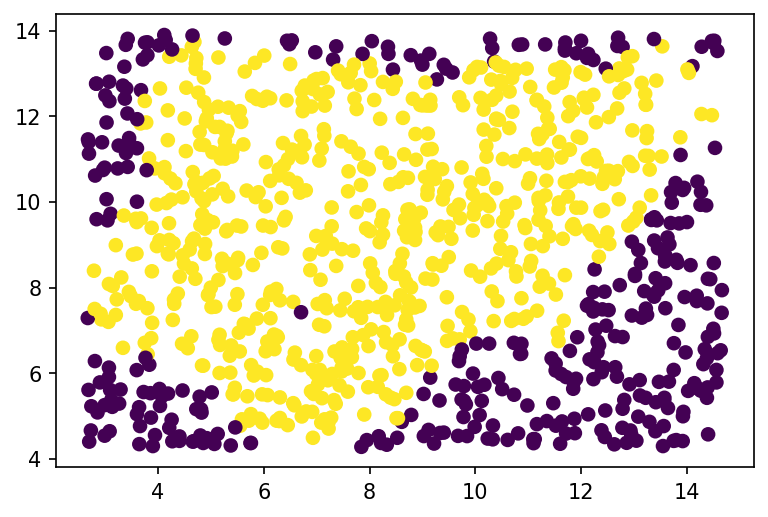

In [19]:
N = 1000 
subset_idx = np.random.choice(len(latlongs[...,0].flatten()),size=N) 

subset=latlongs.reshape(-1,2)[subset_idx,:]

fig,ax = plt.subplots(dpi=150) 
plt.scatter(subset[:,1],subset[:,0],c=~np.isnan(tmp).flatten()[subset_idx]) 
plt.show()

In [153]:
import cartopy.io.shapereader as shpreader

shpfilename = shpreader.natural_earth(resolution='10m',
                                      category='cultural',
                                      name='admin_0_countries')
reader = shpreader.Reader(shpfilename)
countries = reader.records()

ctry_name = "Nigeria" 

ctry_shp = next(filter(lambda x: x.attributes['NAME']==ctry_name,countries)) 